# Deep Neural Networks course - assignment 1
## Michał Filipiuk 385423

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from src.batch_norm import Batch_norm_2d
from src.network import Fruit_conv_net, training, train_to_threshold, get_gradients_of_image, get_losses_of_cutouts, get_loss_of_original
from src.data_loader import load_dataset
from src.config_loader import load_config
from src.utils import *

### Loading configuration and data

In [3]:
config = load_config()
torch.cuda.set_device(config["DEVICE_NUMBER"])

In [5]:
train_class_to_id, train_set_loader = load_dataset(config["DATA_PATH"] + config["TRAIN_PATH"])
test_class_to_id, test_set_loader = load_dataset(config["DATA_PATH"] + config["TEST_PATH"], batch_size=1000)

## Part 1 - Network

### Training of the network with self-implemented batch normalization
#### Source: `src/network.py`, `src/batch_norm.py`

Creating new instance of the neural network

In [6]:
network = Fruit_conv_net().cuda()

We will train the network until it exceeds 97% accuracy as asked in the task.  
If trained a bit longer, this network can get a bit over 98% accuracy.

In [7]:
history_of_accuracy = train_to_threshold(network, train_set_loader, test_set_loader)

Training started
Epoch 0: Accuracy of the network:92.22946227391753%
Epoch 1: Accuracy of the network:92.41824493027221%
Epoch 2: Accuracy of the network:95.65190914073443%
Epoch 3: Accuracy of the network:96.19998782047378%
Epoch 4: Accuracy of the network:94.05030144327385%
Epoch 5: Accuracy of the network:94.3547895986846%
Epoch 6: Accuracy of the network:96.45575787101882%
Epoch 7: Accuracy of the network:97.14390110224713%
Finished Training after 7 epochs


In [8]:
history_of_accuracy[-1]

0.9714390110224712

## Part 2 - Visualisation

Loading image for analysis

In [9]:
train_class_to_id, train_set_loader = load_dataset(config["DATA_PATH"] + config["TRAIN_PATH"], batch_size=1)
id_to_train_class = reverse_dict(train_class_to_id)
images, labels = get_first_image(train_set_loader)
fruit_name = get_fruit_name(id_to_train_class, labels)

#### Sampled fruit

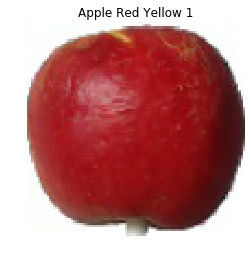

In [10]:
imshow(torchvision.utils.make_grid(images[0]), title=fruit_name)

### Occlusion


#### Hyperparameters

In [11]:
radius_of_kernel = 5
colours = {"R":1,"G":1,"B":1}

I've decided that I will fill the cutout part with white colour as it is the colour of photos' background and would give me more continuous spectrum of loss.  
I had a very tricky situation with a black cutout and a mandarine. The highest loss was in a case when a black square was covering only the white part of the picture.

In [12]:
multiplied_images = multiply_images(images)

In [13]:
make_cutouts(multiplied_images, radius_of_kernel, colours)

#### Example of the cutout

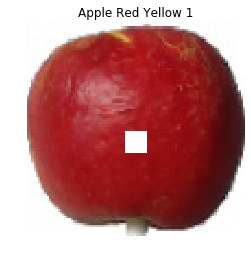

In [14]:
imshow(torchvision.utils.make_grid(multiplied_images[5550].cpu()), title=fruit_name)

In [15]:
aggregated_losses = get_losses_of_cutouts(network, multiplied_images, labels)

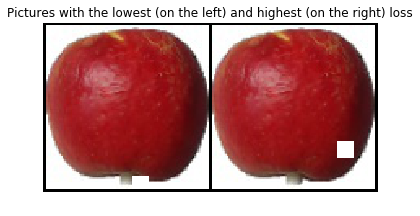

In [16]:
imshow(torchvision.utils.make_grid([multiplied_images[torch.argmin(aggregated_losses)].cpu(), multiplied_images[torch.argmax(aggregated_losses)].cpu()]), title="Pictures with the lowest (on the left) and highest (on the right) loss")

Now, I'm plotting the losses - I divide them by the maximum value of all losses to scale (in this case a totally white pixel represent a point with the highest loss).  
This plot shows effectively which part of the picture is most important for the network to recognize the fruit.

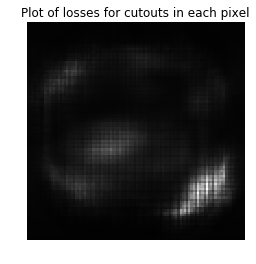

In [17]:
imshow(torchvision.utils.make_grid(aggregated_losses.cpu().view(100,100)/torch.max(aggregated_losses)), title="Plot of losses for cutouts in each pixel")

However, I'd like to analyze also how the original loss compares to cutout losses. Maybe cutting squares by random gives better results than original picture?  
I plotted the histogram of the losses with original (blue line) and mean loss (red dashed line). If average line were to the left of original one, that would mean that statistically it is worth to cut square out to make the task easier for the network.

In [18]:
original_loss = get_loss_of_original(network, images, labels).item()
mean_loss = np.mean(aggregated_losses.view(-1).cpu().numpy())

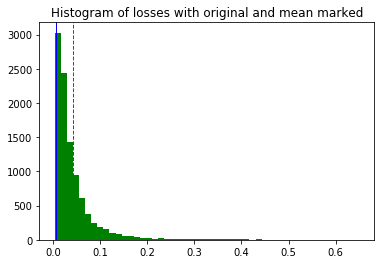

In [19]:
n, bins, patches = plt.hist(aggregated_losses.view(-1).cpu().numpy(), 50, facecolor='g')
plt.axvline(original_loss, color='b', linewidth=1)
plt.axvline(mean_loss, color='r', linestyle='dashed', linewidth=1)
plt.title("Histogram of losses with original and mean marked")
pass

### Gradients

In [20]:
grads = get_gradients_of_image(network, images, labels)

In [21]:
picture = grads.cpu()[0]
R,G,B = grads.cpu()[0]

In [22]:
global_max, global_min, global_abs_max = get_max_min_abs_max(picture)
R_max, R_min, R_abs_max = get_max_min_abs_max(R)
G_max, G_min, G_abs_max = get_max_min_abs_max(G)
B_max, B_min, B_abs_max = get_max_min_abs_max(B)

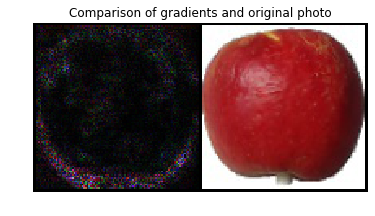

In [23]:
imshow(torchvision.utils.make_grid([(torch.abs(picture))/global_abs_max, images[0]]), title="Comparison of gradients and original photo")

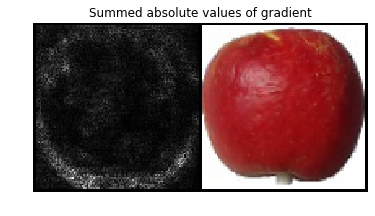

In [24]:
imshow(torchvision.utils.make_grid([multiply_gray_picture(torch.abs(picture).sum(0))/torch.max(torch.abs(picture).sum(0)), images[0]]), title="Summed absolute values of gradient")

Now, let's split the gradient into colour. Plots will show original and absolute values of gradients and the chosen colour casted to grey.  
In original case, the zero gradient is represented as gray colour.
In absolute, the zero gradient is full black.

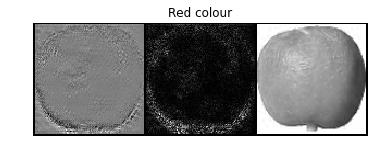

In [25]:
imshow(torchvision.utils.make_grid([multiply_gray_picture((R)/(2*R_abs_max) + 1/2), multiply_gray_picture((torch.abs(R))/(R_abs_max)), multiply_gray_picture(images[0][0])]), title="Red colour")

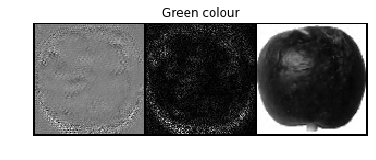

In [26]:
imshow(torchvision.utils.make_grid([multiply_gray_picture((G)/(2*G_abs_max) + 1/2), multiply_gray_picture((torch.abs(G))/(G_abs_max)), multiply_gray_picture(images[0][1])]), title="Green colour")

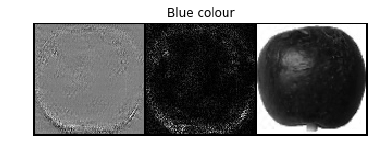

In [27]:
imshow(torchvision.utils.make_grid([multiply_gray_picture((B)/(2*B_abs_max) + 1/2), multiply_gray_picture((torch.abs(B))/(B_abs_max)), multiply_gray_picture(images[0][2])]), title="Blue colour")